In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [15]:
bikes_renal = pd.read_csv('daily-bike-share.csv')
print(bikes_renal.isna().sum())
X = bikes_renal.drop(['rentals'], axis=1).copy()
Y = bikes_renal['rentals'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
rentals       0
dtype: int64


In [5]:
class DiffTempTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["diff_temp"] = (X["atemp"] - X["temp"]) / X["temp"]
        X = X.drop(columns=["atemp", "dteday"], errors="ignore")
        return X

In [6]:
from sklearn.linear_model import Ridge
pipeline = Pipeline(steps=[
    ("diff_temp", DiffTempTransformer()),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

In [7]:
y_test.shape

(183,)

In [18]:
pipeline.fit(X_train, y_train)


,steps,"[('diff_temp', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [22]:
y_pred = pipeline.predict(X_test)

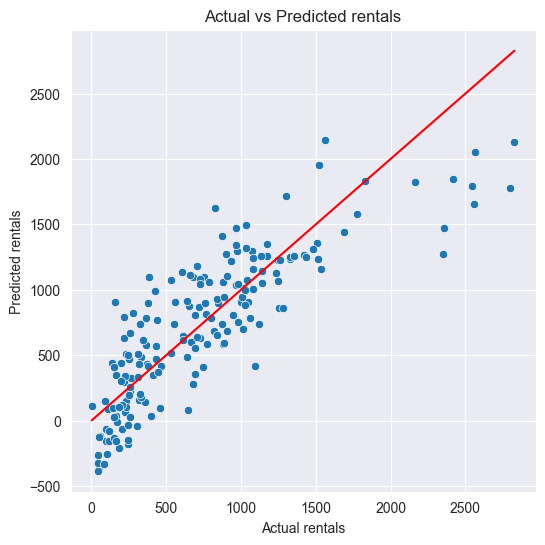

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual rentals")
plt.ylabel("Predicted rentals")
plt.title("Actual vs Predicted rentals")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

MAE : 255.02
RMSE: 106989.53
R²  : 0.690


# Strojenie GridSearch

In [25]:
from sklearn.linear_model import Ridge
pipeline_grid = Pipeline(steps=[
    ("diff_temp", DiffTempTransformer()),
    ("scaler", StandardScaler()),
    ("model", Ridge()) #zmiana modelu bo ten jest też regrsją a ma parametry
])

In [26]:
pipeline_grid.fit(X_train, y_train)

,steps,"[('diff_temp', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [27]:
param_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "model__solver": ["auto", "svd", "cholesky"]
}

In [39]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline_grid,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...], 'model__solver': ['auto', 'svd', ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [30]:
print("Best params:")
print(grid_search.best_params_)

Best params:
{'model__alpha': 10.0, 'model__solver': 'auto'}


In [36]:
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

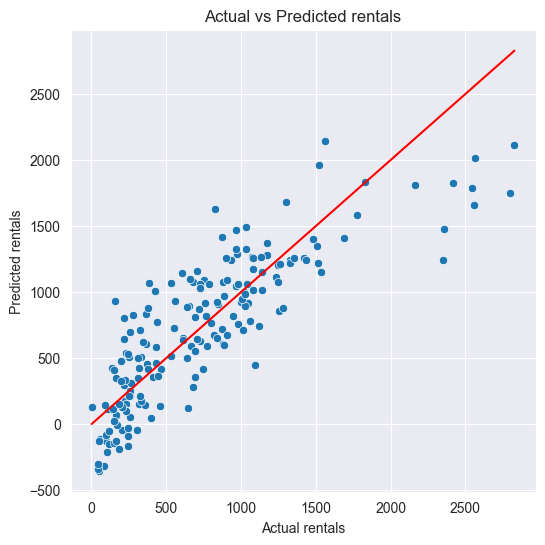

In [37]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_grid)
plt.xlabel("Actual rentals")
plt.ylabel("Predicted rentals")
plt.title("Actual vs Predicted rentals")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()

In [38]:
mae = mean_absolute_error(y_test, y_pred_grid)
rmse = mean_squared_error(y_test, y_pred_grid)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

MAE : 255.02
RMSE: 106989.53
R²  : 0.690


### bez grid, pipiline ręczny
MAE : 255.02
RMSE: 106989.53
R²  : 0.690